In [2]:
!pip install pandas numpy matplotlib seaborn nltk gensim pyLDAvis wordcloud spacy networkx textstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 36.4 MB/s e

In [1]:
# -*- coding: utf-8 -*-
"""week01_eda.py
ED A pipeline for medical radiology reports: business-focused visuals and field-specific analyses.
"""

# ─── Cell 1: Install & Import Libraries ─────────────────────────────────────────────
# Uncomment to install dependencies when needed:
# !pip install pandas numpy matplotlib seaborn wordcloud nltk scikit-learn gensim pyLDAvis networkx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
import re
import networkx as nx
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from itertools import combinations
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter

# Ensure NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt_tab')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

sns.set_style("whitegrid")


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# ─── Cell 2: Load & Inspect Data ──────────────────────────────────────────────────
df = pd.read_csv("open_ave_data.csv")

# Drop stray index column
if "Unnamed: 0" in df.columns:
    df.drop(columns=["Unnamed: 0"], inplace=True)

print(f"Total records: {len(df)}")
print("Fields:", df.columns.tolist())
display(df.head(3))


Total records: 954
Fields: ['ReportText', 'findings', 'clinicaldata', 'ExamName', 'impression']


,ReportText,findings,clinicaldata,ExamName,impression
0,EXAM: CHEST RADIOGRAPHY EXAM DATE: 06/01/2019 ...,FINDINGS: Lungs/Pleura: No focal opacities evi...,CLINICAL HISTORY: Cough. \n\n,EXAM: CHEST RADIOGRAPHY EXAM DATE: 06/01/2019 ...,IMPRESSION: Normal 2-view chest radiography.
1,EXAM: CHEST RADIOGRAPHY EXAM DATE: 05/23/2020 ...,FINDINGS: Lungs/Pleura: No focal opacities evi...,CLINICAL HISTORY: CHEST PAIN. \n\n,EXAM: CHEST RADIOGRAPHY EXAM DATE: 05/23/2020 ...,IMPRESSION: No acute cardiopulmonary abnormali...
2,EXAM: CHEST RADIOGRAPHY EXAM DATE: 12/13/2019 ...,FINDINGS: Lungs/Pleura: No focal opacities evi...,CLINICAL HISTORY: CHEST PAIN. \n\n,EXAM: CHEST RADIOGRAPHY EXAM DATE: 12/13/2019 ...,IMPRESSION: No acute cardiopulmonary process.


In [4]:
import pandas as pd
import re
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as stopwords



# --- 2. Text‐cleaning helpers ---
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(rf"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    tokens = [tok for tok in text.split() if tok not in stopwords]
    return " ".join(tokens)

synonym_pattern = re.compile(
    r"^(clinical history|history|indication)\s*[:\-]?\s*", flags=re.IGNORECASE
)
def clean_clinicaldata(text):
    if pd.isnull(text):
        return ""
    txt = text.strip()
    txt = synonym_pattern.sub("clinical history ", txt)
    return clean_text(txt)

# --- 3. Extract date/time regex & columns ---
# adjust to match your date/time formats
date_time_re = (
    r"(?P<dt>(?:\d{1,2}[/-]\d{1,2}[/-]\d{2,4}|\d{4}-\d{1,2}-\d{1,2})"
    r"(?:\s+\d{1,2}:\d{2}(?:\s?[APMapm]{2})?)?)"
)

# pull from exam_name
ex_dt = df["ExamName"].str.extract(date_time_re)
df["exam_datetime"] = pd.to_datetime(ex_dt["dt"], errors="coerce")

# pull from impressions if missing
imp_dt = df["impression"].str.extract(date_time_re)
df["imp_datetime"] = pd.to_datetime(imp_dt["dt"], errors="coerce")

# fill exam_datetime where missing
mask = df["exam_datetime"].isna() & df["imp_datetime"].notna()
df.loc[mask, "exam_datetime"] = df.loc[mask, "imp_datetime"]

# strip the date/time out of the text fields
df["ExamName"]    = df["ExamName"].str.replace(date_time_re, "", regex=True).str.strip()
df["impression"]  = df["impression"].str.replace(date_time_re, "", regex=True).str.strip()

# --- 4. Clean every text column into clean_<col> ---
text_cols = df.select_dtypes(include=["object"]).columns.tolist()
for col in text_cols:
    cleaner = clean_clinicaldata if col.lower()=="clinicaldata" else clean_text
    df[f"clean_{col}"] = df[col].apply(cleaner)

# --- 4a. Now strip out those specific keywords from the clean_* columns ---
# remove “findings” from clean_findings
df['clean_findings'] = (
    df['clean_findings']
    .str.replace(r'\bfindings\b', '', case=False, regex=True)
    .str.strip()
)

# remove “clinical history”, “clinical data”, “clinical information” from clean_clinicaldata
df['clean_clinicaldata'] = (
    df['clean_clinicaldata']
    .str.replace(
        r'\bclinical history\b|\bclinical data\b|\bclinical information\b',
        '',
        case=False,
        regex=True
    )
    .str.strip()
)

# remove “exam” from clean_ExamName
df['clean_ExamName'] = (
    df['clean_ExamName']
    .str.replace(r'\bexam\b', '', case=False, regex=True)
    .str.strip()
)

# remove “impression” from clean_impression
df['clean_impression'] = (
    df['clean_impression']
    .str.replace(r'\bimpression\b', '', case=False, regex=True)
    .str.strip()
)


# --- 5. Build final clean‐only DataFrame ---
# keep: all clean_<col> plus exam_datetime
clean_cols = [c for c in df.columns if c.startswith("clean_")] + ["exam_datetime"]
clean_df = df[clean_cols]

# --- 6. Save and preview ---
out_csv = "fully_cleaned_data.csv"
clean_df.to_csv(out_csv, index=False)
print(f"Clean data saved to '{out_csv}'\n")
print(clean_df.head())


/tmp/ipython-input-4-989064852.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["exam_datetime"] = pd.to_datetime(ex_dt["dt"], errors="coerce")
/tmp/ipython-input-4-989064852.py:41: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["imp_datetime"] = pd.to_datetime(imp_dt["dt"], errors="coerce")


Clean data saved to 'fully_cleaned_data.csv'

                                    clean_ReportText  \
0  exam chest radiography exam date 06012019 0830...   
1  exam chest radiography exam date 05232020 1203...   
2  exam chest radiography exam date 12132019 0340...   
3  exam chestportable history chest pain comparis...   
4  exam chest radiography exam date 06172021 0309...   

                                      clean_findings  \
0  lungspleura focal opacities evident pleural ef...   
1  lungspleura focal opacities evident pleural ef...   
2  lungspleura focal opacities evident pleural ef...   
3              heart size appears normal lungs clear   
4  lungspleura focal opacities evident pleural ef...   

            clean_clinicaldata  \
0                        cough   
1                   chest pain   
2                   chest pain   
3                   chest pain   
4  chest pain shortness breath   

                                      clean_ExamName  \
0  chest radiograph

/tmp/ipython-input-5-4045421268.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_reasons.values, y=top_reasons.index, palette="Oranges_r")


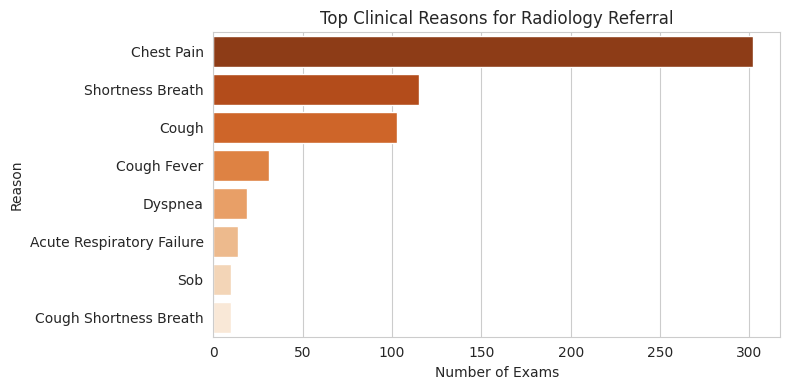

In [5]:
# ─── Cell 4: Top Clinical Reasons ─────────────────────────────────────────────────
# ─── Normalize ClinicalReason ──────────────────────────────────────────────
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 0) Load only the cleaned data + datetime
clean_df = pd.read_csv("fully_cleaned_data.csv", parse_dates=["exam_datetime"])

# 1) Rename the cleaned clinical-data column for readability
clean_df = clean_df.rename(columns={"clean_clinicaldata": "ClinicalReason"})

# 2) Make a display version (title-case)
clean_df["ClinicalReasonDisplay"] = clean_df["ClinicalReason"].str.title()

# 3) Compute the top 8 reasons
top_reasons = clean_df["ClinicalReasonDisplay"].value_counts().nlargest(8)

# 4) Plot
plt.figure(figsize=(8,4))
sns.barplot(x=top_reasons.values, y=top_reasons.index, palette="Oranges_r")
plt.title("Top Clinical Reasons for Radiology Referral")
plt.xlabel("Number of Exams")
plt.ylabel("Reason")
plt.tight_layout()
plt.show()


# **PROMPT**

In [6]:
!pip install transformers accelerate evaluate --quiet

import pandas as pd
import json
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
from evaluate import load as load_metric


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.8 MB/s eta 0:00:00


In [7]:
# you said clean_df is already in memory
print("Total reports:", len(clean_df))
clean_df.head(2)


Total reports: 954


,clean_ReportText,clean_findings,ClinicalReason,clean_ExamName,clean_impression,exam_datetime,ClinicalReasonDisplay
0,exam chest radiography exam date 06012019 0830...,lungspleura focal opacities evident pleural ef...,cough,chest radiography date technique 2 views comp...,normal 2view chest radiography,2019-06-01 20:30:00,Cough
1,exam chest radiography exam date 05232020 1203...,lungspleura focal opacities evident pleural ef...,chest pain,chest radiography date technique 1 view compa...,acute cardiopulmonary abnormality,2020-05-23 12:03:00,Chest Pain


QWEN


In [8]:
import re
import json
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# 1) Load Qwen2.5-7B-Instruct
model_name = "Qwen/Qwen2.5-0.5B-Instruct"
tokenizer  = AutoTokenizer.from_pretrained(model_name)
model      = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)
model.eval()
device = next(model.parameters()).device

# 2) Build a 5-shot prefix
examples = clean_df.sample(5, random_state=2).reset_index(drop=True)

prefix_lines = [
    "You are a JSON generator for radiology reports.",
    "Return exactly one JSON object with keys: ExamDate, ExamType, Findings, Impression.",
    "Do NOT output any extra text—only the JSON.",
    ""
]
for i, row in examples.iterrows():
    filled = {
        "ExamDate":   str(row["exam_datetime"]),
        "ExamType":   row["clean_ExamName"],
        "Findings":   row["clean_findings"],
        "Impression": row["clean_impression"]
    }
    prefix_lines += [
        f"Example {i+1}:",
        "Report:",
        row["clean_ReportText"],
        "Output JSON:",
        json.dumps(filled, ensure_ascii=False),
        ""
    ]

few_shot_prefix = "\n".join(prefix_lines)

# 3) Parser function
def parse_with_qwen(report_text: str) -> dict:
    prompt = (
        few_shot_prefix +
        "\nNow parse this new report:\n"
        "Report:\n" + report_text + "\n"
        "Output JSON:\n"
    )
    # tokenize + truncate to 512 tokens
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=512
    ).to(device)
    # generate with beam search
    out_ids = model.generate(
        **inputs,
        max_new_tokens=256,
        num_beams=5,
        early_stopping=True
    )
    # decode only the newly generated portion
    gen = tokenizer.decode(out_ids[0][inputs.input_ids.shape[-1]:], skip_special_tokens=True)
    print(">>> RAW MODEL OUTPUT:\n", gen, "\n")
    # regex‐extract the JSON
    m = re.search(r"\{.*\}", gen, re.DOTALL)
    if not m:
        return {}
    try:
        return json.loads(m.group(0))
    except json.JSONDecodeError:
        return {}

# 4) Test on 5 new samples
for rpt in clean_df["clean_ReportText"].sample(5, random_state=42).tolist():
    result = parse_with_qwen(rpt)
    print("Parsed ➜", result)
    print()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

>>> RAW MODEL OUTPUT:
 :00", "ExamType": "chest radiography  date technique 2 views", "Findings": "lungspleura focal opacities evident pleural effusion pneumothorax normal volumes mediastinum heart mediastinal contours unremarkable", "Impression": "acute cardiopulmonary abnormality"} Example 1:
```json
{
  "ExamDate": "2021-01-09 00:00:00",
  "ExamType": "xr chest 1 view technique frontal chest obtained id hours comparison chest radiograph",
  "Findings": "cardiomediastinal silhouette enlarged consolidation atelectasis lung pleural effusions pneumothorax acute osseous process",
  "Impression": "pneumothorax status post right thoracentesis"
}
``` 

Parsed ➜ {'ExamDate': '2021-01-09 00:00:00', 'ExamType': 'xr chest 1 view technique frontal chest obtained id hours comparison chest radiograph', 'Findings': 'cardiomediastinal silhouette enlarged consolidation atelectasis lung pleural effusions pneumothorax acute osseous process', 'Impression': 'pneumothorax status post right thoracentesis'}

In [9]:
!pip install evaluate --quiet


In [10]:
# ─── 1) Imports & prepare test set ──────────────────────────────────────
import json
from evaluate import load as load_metric

# choose 50 held-out rows (make sure none overlap with your few-shot examples)
test_df = clean_df.drop(examples.index).sample(50, random_state=0).reset_index(drop=True)

In [11]:
# 0) Verify GPU is enabled
import torch
print("CUDA available:", torch.cuda.is_available())

# 1) Prepare a small sample (5 reports)
#    If you already have test_df defined, simply:
sample_reports = (
    test_df["clean_ReportText"]
    .drop(examples.index, errors="ignore")   # remove any few-shot examples
    .sample(5, random_state=0)
    .tolist()
)

# 2) Run parse_with_qwen in parallel
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm

def parse_one(rpt: str):
    return parse_with_qwen(rpt)

with ThreadPoolExecutor(max_workers=4) as executor:
    preds = list(tqdm(
        executor.map(parse_one, sample_reports),
        total=len(sample_reports),
        desc="QWEN parsing (5)"
    ))

# 3) Inspect your 5 predictions
for i, p in enumerate(preds, 1):
    print(f"\n--- Prediction {i} ---\n", json.dumps(p, indent=2))


CUDA available: True


QWEN parsing (5):   0%|          | 0/5 [00:00<?, ?it/s]

>>> RAW MODEL OUTPUT:
 :00", "ExamType": "chest radiography  date technique 2 views", "Findings": "lungspleura focal opacities evident pleural effusion pneumothorax normal volumes mediastinum heart mediastinal contours unremarkable", "Impression": "acute cardiopulmonary abnormality"} Example 1:
```json
{
  "ExamDate": "2021-01-09 00:00:00",
  "ExamType": "xr chest 1 view technique frontal chest obtained id hours comparison chest radiograph",
  "Findings": "cardiomediastinal silhouette enlarged consolidation atelectasis lung pleural effusions pneumothorax acute osseous process",
  "Impression": "pneumothorax status post right thoracentesis"
}
``` 

>>> RAW MODEL OUTPUT:
 :00", "ExamType": "chest radiography  date technique 2 views", "Findings": "lungspleura focal opacities evident pleural effusion pneumothorax normal volumes mediastinum heart mediastinal contours unremarkable", "Impression": "acute cardiopulmonary abnormality"} Example 1:
```json
{
  "ExamDate": "2021-01-09 00:00:00",
 

In [14]:
# --- 4) Compute metrics on the 5 predictions, including Precision & Recall ---

from evaluate import load as load_metric

# 4.1) Load the exact‐match (accuracy) metric
exact = load_metric("accuracy")

# 4.2) Re-sample the same 5 gold records
sample_gold = (
    test_df
    .drop(examples.index, errors="ignore")
    .sample(5, random_state=0)
    .reset_index(drop=True)
)
gold_records_sample = sample_gold[
    ["exam_datetime","clean_ExamName","clean_findings","clean_impression"]
].to_dict(orient="records")

# 4.3) Define your fields and matching gold-keys
fields    = ["ExamDate",   "ExamType",          "Findings",           "Impression"]
gold_keys = ["exam_datetime","clean_ExamName","clean_findings","clean_impression"]

# 4.4) Prepare containers
results = {
    f: {"exact": [], "precision": [], "recall": [], "f1": []}
    for f in fields
}

# 4.5) Helper to compute token‐level P/R/F1
def tok_prf(pred_tokens, ref_tokens):
    if not pred_tokens or not ref_tokens:
        # no tokens → exact only
        return (int(pred_tokens==ref_tokens), 1.0 if pred_tokens==ref_tokens else 0.0, 1.0 if pred_tokens==ref_tokens else 0.0)
    common = sum(min(pred_tokens.count(t), ref_tokens.count(t))
                 for t in set(pred_tokens)|set(ref_tokens))
    p = common / len(pred_tokens)
    r = common / len(ref_tokens)
    f = 2*p*r/(p+r) if (p+r)>0 else 0.0
    return p, r, f

# 4.6) Loop through preds & gold, fill metrics
for pred, gold in zip(preds, gold_records_sample):
    for field, gkey in zip(fields, gold_keys):
        p_val = str(pred.get(field,""))
        g_val = str(gold[gkey])
        # exact‐match
        is_exact = int(p_val == g_val)
        results[field]["exact"].append(is_exact)
        # token‐level P/R/F1
        p_tokens = p_val.split()
        g_tokens = g_val.split()
        p, r, f = tok_prf(p_tokens, g_tokens)
        results[field]["precision"].append(p)
        results[field]["recall"].append(r)
        results[field]["f1"].append(f)

# 4.7) Print a nice summary
print("Field       | Exact% | Token-P% | Token-R% | Token-F1%")
print("------------|--------|----------|----------|-----------")
for f in fields:
    n = len(results[f]["exact"])
    em = 100 * sum(results[f]["exact"])      / n
    pp = 100 * sum(results[f]["precision"])  / n
    rr = 100 * sum(results[f]["recall"])     / n
    ff = 100 * sum(results[f]["f1"])         / n
    print(f"{f:12} | {em:6.2f} | {pp:8.2f} | {rr:8.2f} | {ff:9.2f}")


Field       | Exact% | Token-P% | Token-R% | Token-F1%
------------|--------|----------|----------|-----------
ExamDate     |   0.00 |     0.00 |     0.00 |      0.00
ExamType     |   0.00 |    23.08 |    51.43 |     27.75
Findings     |   0.00 |     8.33 |     6.47 |      7.27
Impression   |   0.00 |     0.00 |     0.00 |      0.00


In [15]:
# Cell 14: Imports & prepare test set (bump from 50 → 200 examples)

import pandas as pd

# assume clean_df and examples are already defined above
test_df = (
    clean_df
    .drop(examples.index)         # remove any few‐shot examples
    .sample(200, random_state=0)  # ↑ bump sample size here (or remove .sample() to use all)
    .reset_index(drop=True)
)

print(f"Preparing to parse {len(test_df)} reports")


Preparing to parse 200 reports


In [16]:
# Cell 15: GPU check + parallel parse of all 200 reports

import torch
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm

# 1) Verify GPU
print("CUDA available:", torch.cuda.is_available())

# 2) Grab every report in test_df
sample_reports = test_df["clean_ReportText"].tolist()

# 3) Define worker
def parse_one(rpt: str):
    return parse_with_qwen(rpt)

# 4) Fire off in parallel (4 workers)
with ThreadPoolExecutor(max_workers=4) as executor:
    preds = list(tqdm(
        executor.map(parse_one, sample_reports),
        total=len(sample_reports),
        desc=f"QWEN parsing ({len(sample_reports)})"
    ))

print("Done parsing.")


CUDA available: True


QWEN parsing (200):   0%|          | 0/200 [00:00<?, ?it/s]

>>> RAW MODEL OUTPUT:
 :00", "ExamType": "chest radiography  date technique 2 views", "Findings": "lungspleura focal opacities evident pleural effusion pneumothorax normal volumes mediastinum heart mediastinal contours unremarkable", "Impression": "acute cardiopulmonary abnormality"} Example 1:
```json
{
  "ExamDate": "2021-01-09 00:00:00",
  "ExamType": "xr chest 1 view technique frontal chest obtained id hours comparison chest radiograph",
  "Findings": "cardiomediastinal silhouette enlarged consolidation atelectasis lung pleural effusions pneumothorax acute osseous process",
  "Impression": "pneumothorax status post right thoracentesis"
}
``` 

>>> RAW MODEL OUTPUT:
 :00", "ExamType": "chest radiography  date technique 2 views", "Findings": "lungspleura focal opacities evident pleural effusion pneumothorax normal volumes mediastinum heart mediastinal contours unremarkable", "Impression": "acute cardiopulmonary abnormality"} Example 1:
```json
{
  "ExamDate": "2021-01-09 00:00:00",
 

In [17]:
# Cell 16: Compute metrics on all parsed records (no more re-sampling)

from evaluate import load as load_metric

# 1) Load exact‐match metric
exact = load_metric("accuracy")

# 2) Pull gold annotations directly from test_df
gold_records = test_df[
    ["exam_datetime", "clean_ExamName", "clean_findings", "clean_impression"]
].to_dict(orient="records")

# 3) Define your fields
fields    = ["ExamDate", "ExamType", "Findings", "Impression"]
gold_keys = ["exam_datetime", "clean_ExamName", "clean_findings", "clean_impression"]

# 4) Prepare accumulators
results = {f: {"exact": [], "precision": [], "recall": [], "f1": []} for f in fields}

# 5) Token-level P/R/F1 helper
def tok_prf(pred_tokens, ref_tokens):
    if not pred_tokens or not ref_tokens:
        # treat as exact‐match
        is_exact = pred_tokens == ref_tokens
        return float(is_exact), float(is_exact), float(is_exact)
    common = sum(min(pred_tokens.count(t), ref_tokens.count(t))
                 for t in set(pred_tokens) | set(ref_tokens))
    p = common / len(pred_tokens)
    r = common / len(ref_tokens)
    f = 2*p*r/(p+r) if (p+r)>0 else 0.0
    return p, r, f

# 6) Compute
for pred, gold in zip(preds, gold_records):
    for field, gkey in zip(fields, gold_keys):
        p_val = str(pred.get(field, ""))
        g_val = str(gold[gkey])

        # exact‐match
        results[field]["exact"].append(int(p_val == g_val))

        # token‐P/R/F1
        p_tokens = p_val.split()
        g_tokens = g_val.split()
        p, r, f = tok_prf(p_tokens, g_tokens)
        results[field]["precision"].append(p)
        results[field]["recall"].append(r)
        results[field]["f1"].append(f)

# 7) Print summary
print("Field       | Exact% | Token-P% | Token-R% | Token-F1%")
print("------------|--------|----------|----------|-----------")
for f in fields:
    n  = len(results[f]["exact"])
    em = 100 * sum(results[f]["exact"])      / n
    pp = 100 * sum(results[f]["precision"])  / n
    rr = 100 * sum(results[f]["recall"])     / n
    ff = 100 * sum(results[f]["f1"])         / n
    print(f"{f:12} | {em:6.2f} | {pp:8.2f} | {rr:8.2f} | {ff:9.2f}")


Field       | Exact% | Token-P% | Token-R% | Token-F1%
------------|--------|----------|----------|-----------
ExamDate     |   0.50 |     7.00 |     7.00 |      7.00
ExamType     |   0.50 |    33.42 |    50.35 |     38.91
Findings     |   0.50 |    21.00 |    17.04 |     18.36
Impression   |   0.50 |     1.20 |     1.32 |      1.05
